<a href="https://colab.research.google.com/github/juwetta/DLI_Group-B/blob/main/TP074003_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount google drive and import dataset

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PSO-XGBoost

No constraints given.
Best after iteration 1: [79.685694    0.48118136  0.48663377  0.13079206] -0.9933832198455282
Best after iteration 2: [79.685694    0.48118136  0.48663377  0.13079206] -0.9933832198455282
New best for swarm at iteration 3: [80.64540156  0.5         0.5         0.14431799] -0.9935285202203671
Best after iteration 3: [80.64540156  0.5         0.5         0.14431799] -0.9935285202203671
Best after iteration 4: [80.64540156  0.5         0.5         0.14431799] -0.9935285202203671
Best after iteration 5: [80.64540156  0.5         0.5         0.14431799] -0.9935285202203671
Best after iteration 6: [80.64540156  0.5         0.5         0.14431799] -0.9935285202203671
New best for swarm at iteration 7: [50.          0.5         0.5         0.16765308] -0.9952449567723343
Best after iteration 7: [50.          0.5         0.5         0.16765308] -0.9952449567723343
Best after iteration 8: [50.          0.5         0.5         0.16765308] -0.9952449567723343
Best after itera

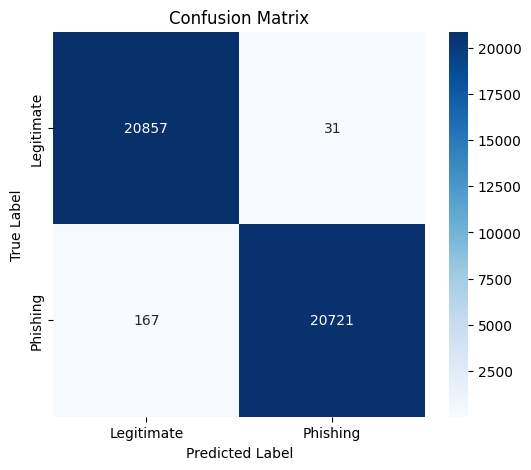

In [1]:
!pip install xgboost pyswarm

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
import xgboost as xgb
from pyswarm import pso
from urllib.parse import urlparse
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# ---------------- Load dataset ----------------
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Assignment/URL_dataset_clean_balanced.csv')

#dataset = dataset.sample(1000, random_state=42)  # test with 1k rows


# ---------------- Feature extraction ----------------
def extract_url_features(url: str):
    try:
        s = str(url)
        p = urlparse(s)
        host = p.hostname or ""
        path = p.path or ""
        query = p.query or ""
        lower = s.lower()
        feats = {
            "url_len": len(s),
            "host_len": len(host),
            "path_len": len(path),
            "query_len": len(query),
            "n_dots": lower.count('.'),
            "n_hyphens": lower.count('-'),
            "n_slash": lower.count('/'),
            "n_qmark": lower.count('?'),
            "n_eq": lower.count('='),
            "n_and": lower.count('&'),
            "n_at": lower.count('@'),
            "n_pct": lower.count('%'),
            "n_digits": sum(c.isdigit() for c in lower),
            "has_ip": 1 if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', host) else 0,
            "https": 1 if lower.startswith('https') else 0,
            "has_www": 1 if 'www' in host else 0,
            "n_params": (query.count('&') + (1 if '=' in query else 0)),
            "subdomains": max(0, len(host.split('.')) - 2) if host else 0,
        }
        return pd.Series(feats)
    except:
        return pd.Series([0]*18, index=[
            "url_len","host_len","path_len","query_len","n_dots","n_hyphens",
            "n_slash","n_qmark","n_eq","n_and","n_at","n_pct","n_digits",
            "has_ip","https","has_www","n_params","subdomains"
        ])

X_feats = dataset['url'].astype(str).apply(extract_url_features)
le = LabelEncoder()
y = le.fit_transform(dataset['type'])

# ---------------- Train/test split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X_feats.values, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------- PSO Objective Function ----------------
def objective(params):
    nrounds, eta, lmbda, alpha = params
    model = xgb.XGBClassifier(
        booster='gblinear',          # XgbLinear
        n_estimators=int(nrounds),   # nrounds
        learning_rate=eta,
        reg_lambda=lmbda,
        reg_alpha=alpha,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        verbosity=0
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -f1_score(y_test, y_pred)

# ---------------- PSO (Table 4 params) ----------------
#lb = [10, 0.0, 0.0001, 0.0001]   # nrounds, eta, lambda, alpha lower bounds (original)
#ub = [500, 1.0, 1.0, 1.0]        # upper bounds (original)

lb = [50, 0.1, 0.1, 0.1]
ub = [150, 0.5, 0.5, 0.5]


best_params, best_score = pso(
    func=objective,
    lb=lb,
    ub=ub,
    swarmsize=5,                 # Particles number (10)original
    maxiter=30,                  # Max iterations (100)original
    omega=0.7,                    # inertia weight (avg of 0.4–0.9)
    phip=1.193,                   # local learning factor C2
    phig=1.193,                   # global learning factor C1
    debug=True
)

best_nrounds, best_eta, best_lambda, best_alpha = best_params
print("Best Params Found by PSO:")
print(f"nrounds={int(best_nrounds)}, eta={best_eta:.3f}, lambda={best_lambda:.3f}, alpha={best_alpha:.3f}")
print(f"Best F1 Score: {-best_score:.3f}")

# ---------------- Train final XgbLinear model ----------------
final_model = xgb.XGBClassifier(
    booster='gblinear',
    n_estimators=int(best_nrounds),
    learning_rate=best_eta,
    reg_lambda=best_lambda,
    reg_alpha=best_alpha,
    eval_metric='logloss',
    n_jobs=-1
)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print("Final F1 Score:", f1_score(y_test, y_pred))


# =========================================================
#             Summary Table for PSO-tuned XgbLinear
# =========================================================
# Inference time
start_time = time.time()
_ = final_model.predict(X_test)
inference_time = (time.time() - start_time) / len(X_test) * 1000  # ms/sample

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])

# ASCII table helper
def _ascii_table(headers, rows):
    widths = [max(len(str(x)) for x in col) for col in zip(*([headers] + rows))]

    def fmt(text, width, center=False):
        text = str(text)
        pad = width - len(text)
        if center:
            left = pad // 2
            right = pad - left
            return ' ' * (left + 1) + text + ' ' * (right + 1)
        else:
            return ' ' + text + ' ' * (pad + 1)

    def line():
        return '+' + '+'.join('-' * (w + 2) for w in widths) + '+'

    out = [line(),
           '|' + '|'.join(fmt(h, w, center=True) for h, w in zip(headers, widths)) + '|',
           line()]
    for r in rows:
        out.append('|' + '|'.join(fmt(c, w, center=True) for c, w in zip(r, widths)) + '|')
    out.append(line())
    return '\n'.join(out)

# Collect row for summary
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC", "Params", "Inference(ms)"]
row = [
    "PSO+XgbLinear",
    f"{accuracy:.3f}",
    f"{precision:.3f}",
    f"{recall:.3f}",
    f"{f1:.3f}",
    f"{roc_auc:.3f}",
    f"nrounds={int(best_nrounds)}, eta={best_eta:.3f}, λ={best_lambda:.3f}, α={best_alpha:.3f}",
    f"{inference_time:.3f}"
]

print("\nClassification Report:\n")
print(_ascii_table(headers, [row]))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legitimate", "Phishing"],
            yticklabels=["Legitimate", "Phishing"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()